# Training: Neuronales Netzwerk mit dem Tuner von Weights & Biases

In diesem Notebook wird ein neuronales Netzwerk mit den im Notebook `wandb_tuning.ipynb`optimierten Hyperparametern trainiert. Dabei wurde dieser Prozess auf zwei seperate Notebooks aufgeteilt, weilch ich das Problem hatte, dass das Training nach dem Tuning nicht mehr zuverlässig  durchgelaufen ist und die Ergebnisse auf die letzte Sweep im Wandb Dashboard geschrieben wurden, obwohl das Tuning bereits beendet war. Dieses Verhalten kann im Notebook `train_wandb_tuning.ipynb` nachvollzogen werden.

Zunächst müssen die benötigten Bibliotheken importiert werden.

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import os
import keras_tuner as kt
import wandb
import tqdm
import tensorflow as tf
import keras
import seaborn as sns

from tensorflow.keras import layers, Model, optimizers, losses, callbacks
from tensorflow import GradientTape
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from wandb.integration.keras import WandbMetricsLogger
from sklearn.metrics import confusion_matrix

## Zugrif auf gewollte Sweep

Zunächst müssen hier manuell die Sweep-ID und die Projekt-ID des gewünschten Sweeps eingetragen werden.

In [2]:
sweep_id = "lj0f8np5"
project_name = "lokrau"

Nun kann damit auf die Wandb-API zugegriffen werden, um die besten Hyperparameter zu erhalten.

In [3]:
api = wandb.Api()
sweep_id = project_name + '/credit_card/sweeps/' + sweep_id

sweep = api.sweep(sweep_id)
runs = sweep.runs

Diese werden in eine Liste gespeichert.

In [4]:
results = []
for run in runs:
    run_data = {
        'batch_size': run.config.get('batch_size'),
        'val_accuracy': run.summary.get('val_acc'),
        'val_loss': run.summary.get('val_loss'),
        'accuracy': run.summary.get('acc'),
        'loss': run.summary.get('loss'),
    }
    results.append(run_data)

In [5]:
results_df = pd.DataFrame(results)
results_df

,batch_size,val_accuracy,val_loss,accuracy,loss
0,512,0.497396,52.849962,0.447206,33.588444
1,256,0.510510,3.600855,0.461535,13.944678
2,128,0.523717,1.654581,0.532605,1.178922
3,64,0.551246,1.345409,0.533721,3.202749
4,32,0.505301,0.853156,0.522999,0.753955


Nun kann die Batchsize, welche den geringsten Validation Loss erzielt hat, ausgewählt werden.

In [6]:
best_run = results_df.loc[results_df['val_loss'].idxmin()]
best_batch_size = best_run['batch_size']
best_val_loss = best_run['val_loss']

In [7]:
print(f'Best batch size: {best_batch_size} with validation loss: {best_val_loss}')

Best batch size: 32.0 with validation loss: 0.8531560952819529


## Training

Nun müssen die Datensätze für das Training eingelesen werden.

In [8]:
train = pd.read_csv('../data/preprocessed/train_data.csv')
test = pd.read_csv('../data/preprocessed/test_data.csv')
val = pd.read_csv('../data/preprocessed/val_data.csv')

In [9]:
train.shape, test.shape, val.shape

((50176, 48), (5469, 48), (10752, 48))

In [10]:
X_train = train.drop("Is high risk", axis=1)
Y_train = train["Is high risk"]

X_test = test.drop("Is high risk", axis=1)
Y_test = test["Is high risk"]

X_val = val.drop("Is high risk", axis=1)
Y_val = val["Is high risk"]

Nun wird das Modell so wie im Notebook `wandb_tuning.ipynb` definiert, um dieses anschließend genau so zu trainieren.

In [11]:
def Model():
    x = layers.Input(shape=(X_train.shape[1],))

    h = layers.Dense(64, activation='relu')(x)
    h = layers.Dense(64, activation='relu')(h)
    h = layers.Dense(64, activation='relu')(h)
    h = layers.Dense(64, activation='relu')(h)

    y = layers.Dense(1, activation='sigmoid')(h)

    model = keras.Model(inputs=x, outputs=y)

    return model

In [12]:
model = Model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 47)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

Dabei wird mithilfe des Validierungsdatensatzes ein Early Stopping implementiert, um das Training zu stoppen, wenn der Validierungsfehler nicht mehr sinkt.

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,     # Minimum change to qualify as an improvement
    patience=100,         # How many epochs to wait after last time val loss improved
    verbose=1,
    mode='min',          # The training will stop when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

Als Optimizer wird der Adam-Optimizer verwendet und als Loss-Funktion die Binary Crossentropy.

In [14]:
optimizer = optimizers.Adam(learning_rate=0.001, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            amsgrad=True)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Nun können die Batchsize aus dem Hyperparameter-Tuning verwendet werden um das Modell zu trainieren. Außerdem werden die Epochen auf 1000 gesetzt.

In [15]:
batch_size = int(best_batch_size)
epochs = 1000

Nun kann ein neuer Wandb-Run gestartet werden, um die Ergebnisse des Trainings zu speichern. Dabei werden alle Parameter festgelegt wie mit dem Run gespeichert werden sollen.

In [16]:
# wandb.login()

In [17]:
run = wandb.init(project='ml_assignment_wandb',
                 reinit = True,
                 config={
                     "learning_rate": 0.001, 
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": "BinaryCrossentropy",
                     "architecture": "Dense(64, relu) -> Dense(64, relu) -> Dense(64, relu) -> Dense(64, relu) -> Dense(1, sigmoid)",
                     "dataset": "Credit Card",
                     "optimizer": "Adam"})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lokrau2002 (lokrau). Use `wandb login --relogin` to force relogin


Nun kann das Modell basierend auf den Trainings- und Validierungsdaten trainiert werden.

In [18]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping, WandbMetricsLogger()],
                    epochs=epochs)

if not os.path.exists('../models'):
    os.makedirs('../models')

model.save('../models/model_wandb_tuning.h5')

Epoch 1/1000
1537/1568 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.5069 - loss: 229.4531

wandb: ERROR Unable to log learning rate.


1568/1568 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - accuracy: 0.5069 - loss: 226.5117 - val_accuracy: 0.5081 - val_loss: 13.2188
Epoch 2/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.5220 - loss: 7.0306 - val_accuracy: 0.5020 - val_loss: 2.3146
Epoch 3/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.5250 - loss: 2.1883 - val_accuracy: 0.5165 - val_loss: 1.6513
Epoch 4/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.5324 - loss: 1.0530 - val_accuracy: 0.4964 - val_loss: 1.4302
Epoch 5/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.5353 - loss: 1.0306 - val_accuracy: 0.4938 - val_loss: 0.9432
Epoch 6/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.5374 - loss: 0.8843 - val_accuracy: 0.5287 - val_loss: 0.8294
Epoch 7/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.5452 - loss: 0.8977 - val_accuracy: 0.5348 - val_loss: 0.8909
Epoch 8/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.

In [19]:
wandb.finish()

epoch/accuracy,▁▁▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/loss,▇█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▃▄▄▃▆▅▅▇▇▇▆██▅▇▇███▇██████▇▇▇▇████▇██
epoch/val_loss,█▄▃▄▃▃▄▂▂▃▂▂▂▂▁▁▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁
epoch/accuracy,0.80385
epoch/epoch,469
epoch/loss,0.38172
epoch/val_accuracy,0.84533
epoch/val_loss,0.37678


Nun wird der Trainingsverlauf des Modells für Accuracy und Loss visualisiert.

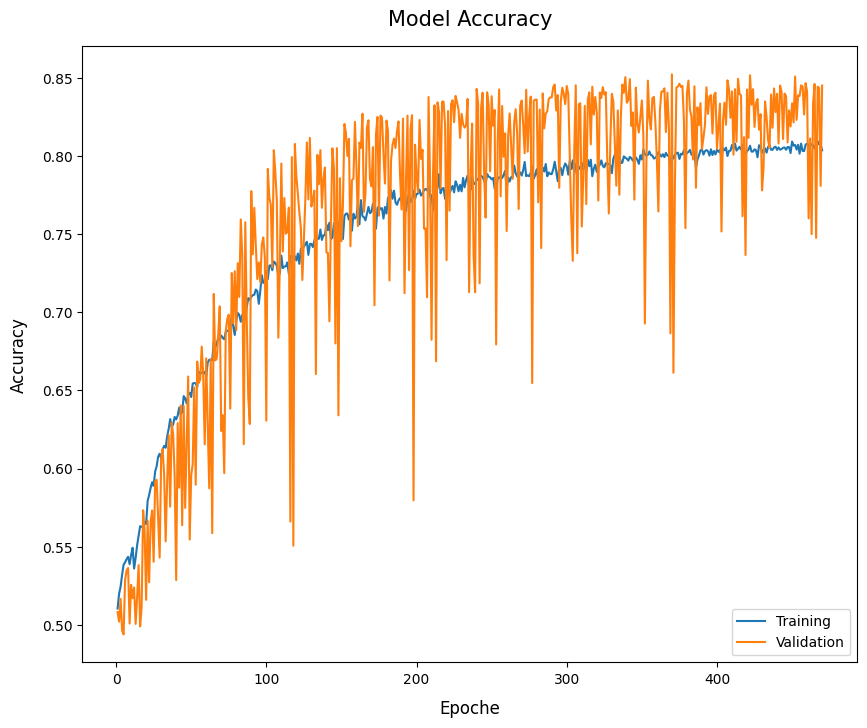

In [20]:
# Print the model training history for accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Model Accuracy', fontsize=15, pad=15)
plt.ylabel('Accuracy', fontsize=12, labelpad=10)
plt.xlabel('Epoche', fontsize=12, labelpad=10)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

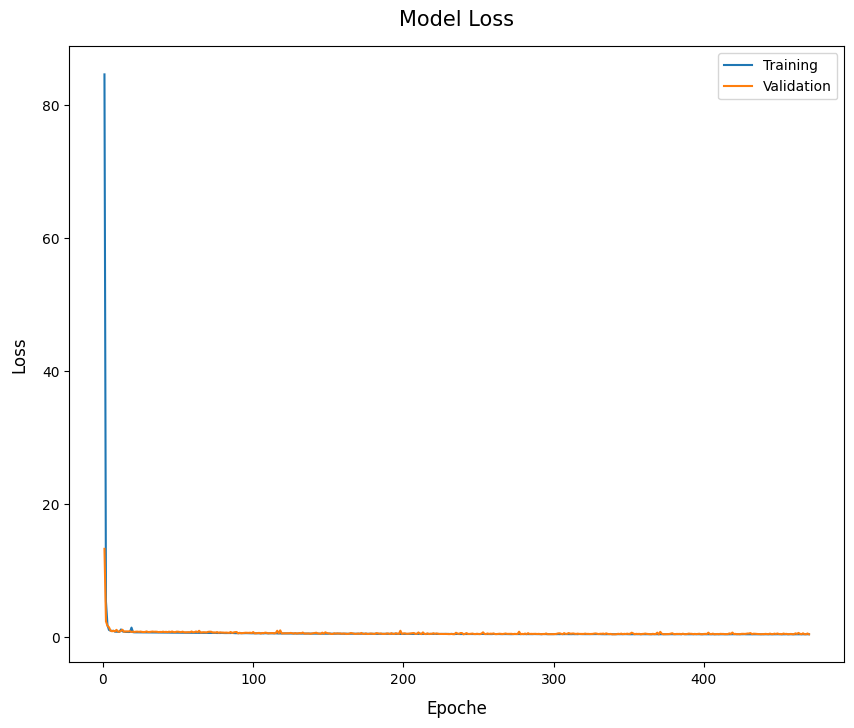

In [21]:
# print the model training history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Model Loss', fontsize=15, pad=15)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.xlabel('Epoche', fontsize=12, labelpad=10)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Anschließend wird das Modell auf die drei zur verfügung stehenden Datensätze evaluiert und es ist zu erkennen, dass die Ergebnisse auf die drei Datensätze sehr ähnlich sind.

In [22]:
model.evaluate(X_test, Y_test)

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.7729 - loss: 0.3529


[0.3554687201976776, 0.7710733413696289]

In [23]:
model.evaluate(X_val, Y_val)

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - accuracy: 0.8047 - loss: 0.3441


[0.36128315329551697, 0.8524925708770752]

In [24]:
model.evaluate(X_train, Y_train)

1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 355us/step - accuracy: 0.7885 - loss: 0.3370


[0.34364238381385803, 0.8194555044174194]

Abschließend wird noch eine Confusion Matrix für die Testdaten erstellt, um die Ergebnisse des Modells zu visualisieren.

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


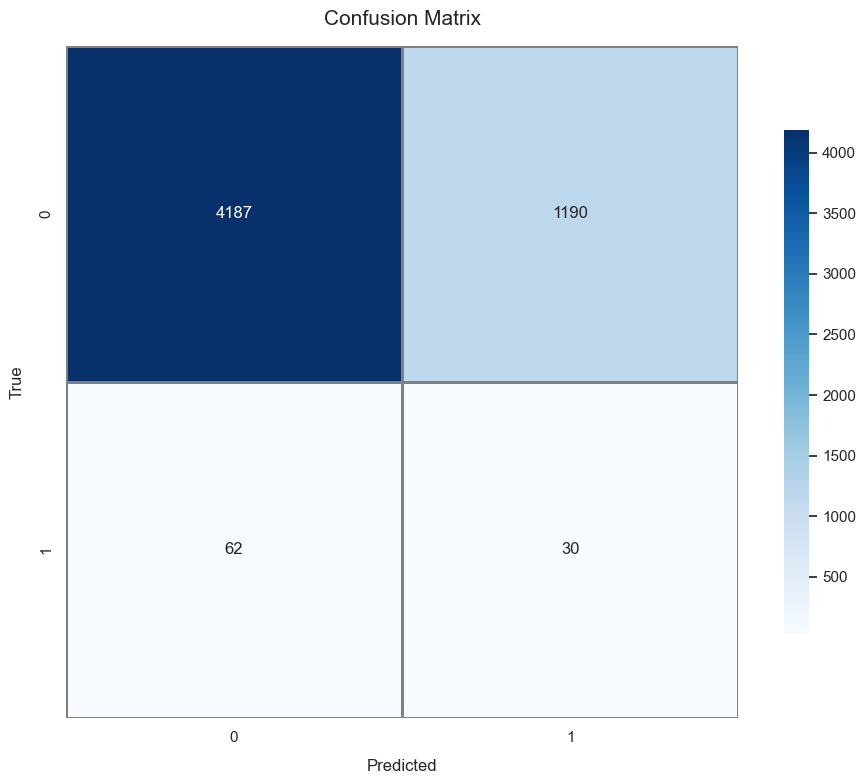

In [25]:
# make a confusion matrix for the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(Y_test, y_pred)

# Set the style of the heatmap
sns.set_theme(style="whitegrid")

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', square=True, cmap='Blues', cbar_kws={'shrink': 0.75}, linewidths=1, linecolor='grey')

# Add labels
plt.xlabel('Predicted', fontsize=12, labelpad=10)
plt.ylabel('True', fontsize=12, labelpad=10)
plt.title('Confusion Matrix', fontsize=15, pad=15)

# Improve the layout
plt.tight_layout()

# Display the plot
plt.show()
